# Example of Analysis

*Oskar schade*

This notebook comprises an example of the type of analysis conducted in the project.

*   The baseline model is loaded
*   The fine-tuned model is then loaded
*   Predictions are made on a randomly selected image
*   The result is inspected, aswell as a probability map
*   A probability threshold is adjusted and the mask is overlaid on the image

As the imagery and model used must be located in a specified directory, this notebook should not be viewed as fully functioning code, but an illustrative example. In this particular example, to the images have been derived from an informal settlement.

*The intial cells of this notebook have drawn inspiration from the following source:
https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb

# Installation and general imports

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install rasterio
!pip install datasets
!pip install git+https://github.com/facebookresearch/segment-anything.git # Installing the base Segment Anything Model

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-v7czmihl
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-v7czmihl
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=fd0dbf97cdc84f259ee96119bf2a837651f512d25a957d8e18efa2b11cf82bae
  Stored in directory: /tmp/pip-ephem-wheel-cache-b9n3rd0z/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
import random
import torch
import io
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
from datasets import Dataset
from torch.utils.data import IterableDataset, DataLoader
from transformers import SamProcessor
from transformers import SamModel
from statistics import mean
from contextlib import redirect_stdout

*As this notebook was developed in Google Collab, the notebook must be mounted

In [ ]:
# Providing access to Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading base SAM model

In [ ]:
# Defining the SAM processer
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
model = SamModel.from_pretrained("facebook/sam-vit-base")

for layer_name, param in model.named_parameters():
    if layer_name.startswith("vision_encoder") or layer_name.startswith("prompt_encoder"): # Freezing layers that are not finetuned
        param.requires_grad = False
device = "cuda" if torch.cuda.is_available() else "cpu" # Using GPU if it is available
model.to(device)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [ ]:
# Loading the fine-tuned model
model_save_path = '/content/drive/MyDrive/Thesis/Models/SAM_43_epochs_7_11.pth' # As this notebook was developed in Google Drive, a drive directory must be defined here.

model.load_state_dict(torch.load(model_save_path))

<ipython-input-7-cbae42c3cc3e>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


<All keys matched successfully>

________________________________________________________________________________


# Analysis of random images from informal settlements

In [ ]:
# Setting a directory of images to analyze
images = # Again, As the model was developed in Google Colab, a Drive directory is provided here

Selected image: patch_400_160.tif


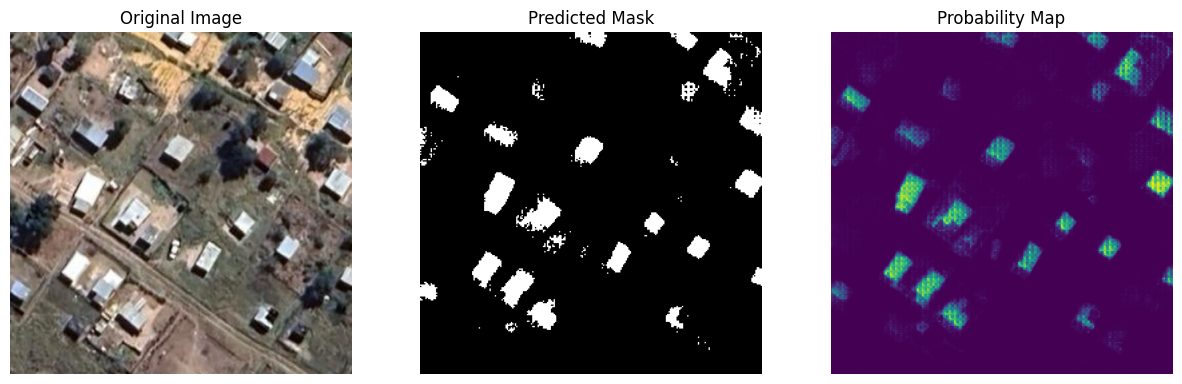

In [ ]:
# Finding all image files, based on file extensions
files_names = sorted([f for f in os.listdir(images) if f.endswith(('.jp', '.jpeg', '.png', '.tif', '.tiff'))])

# Choosing a random image to analyze
random_image = random.choice(files_names)
print(f"Selected Image: {random_image}")

# Load the selected image, and defining it as inputs
image_path = os.path.join(images, random_image)
original_image = np.array(Image.open(image_path).convert("RGB")) # Converting to array
original_image_pil = Image.fromarray(original_image) # Converting to PIL image
image_inputs = processor(original_image_pil, return_tensors="pt")
image_inputs = {k: v.to(device) for k, v in image_inputs.items()}

# Setting model in evalutation mode to allow for prediction
model.eval()
with torch.no_grad():
    outputs = model(pixel_values=image_inputs["pixel_values"], multimask_output=False)
    predicted_mask = outputs.pred_masks.squeeze(1).sigmoid().cpu().numpy() # Creating probability map from prediction

# Ensuring that the prediction has the proper dimensions
mask_tensor = torch.tensor(predicted_mask).squeeze()
if mask_tensor.ndim == 2:
    mask_tensor = mask_tensor.unsqueeze(0).unsqueeze(0)

# Upsizing the predicted mask to comply with the image source
mask_scaled = F.interpolate(
    mask_tensor,
    size=(512, 512), # Size of the imagery used
    mode="nearest"
).squeeze().numpy()

# Setting a probability threshold for a binary mask
final_mask = (mask_scaled > 0.1).astype(np.uint8)

# Displaying the image alongside the binary mask and probability map
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(final_mask, cmap="gray")
axes[1].set_title("Predicted Mask")
axes[1].axis("off")

axes[2].imshow(mask_scaled, cmap="viridis")
axes[2].set_title("Probability Map")
axes[2].axis("off")

plt.show()


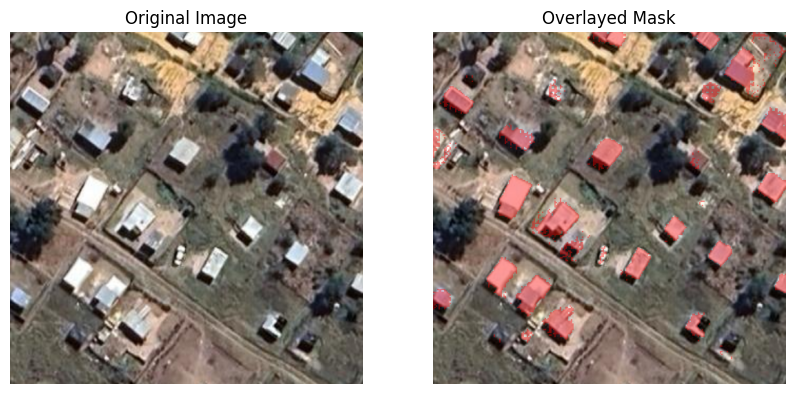

In [ ]:
# Refining the threshold based on inspection and recreating mask
refined_threshold = 0.08
adjusted_mask = (mask_scaled > refined_threshold).astype(np.uint8)

# Creating and image overlay by blending image and mask with transparency
overlay = original_image.copy()
overlay[adjusted_mask > 0] = [255, 0, 0]

alpha = 0.4 # Setting a transparency value
image_overlay = (alpha * overlay + (1 - alpha) * original_image).astype(np.uint8)

# Displaying the image alongside the overlay
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(image_overlay)
axes[1].set_title(f"Overlayed Mask")
axes[1].axis("off")

plt.show()

### Estimating dwelling coverage

In [ ]:
# Deriving class divison from pixels

# summing pixels with a value that is higher than 0, to derive dwellings
dwellings = np.sum(final_mask > 0)
# Counting all pixels in the image
total_pixels = final_mask.size
# Deriving non-dwellings
non_dwellings = total_pixels - dwellings

# Defining percentages and printing the class division
dwelling_percentage = (dwellings / total_pixels) * 100
non_dwelling_percentage = (non_dwellings / total_pixels) * 100

print(f"Division of dwellings vs. non dwellings:")
print(f"Dwellings: {dwelling_percentage:.2f}%")
print(f"Non-dwellings: {non_dwelling_percentage:.2f}%")


Division of dwellings vs. non dwellings:
Dwellings: 8.11%
Non-dwellings: 91.89%


_____________________________________________________